In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.widgets import Button
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
%matplotlib widget

import h5py 
import os,sys,glob
import pandas as pd
import ipympl

In [2]:
visitpath = '/dls/staging/dls/k11/data/2024/mg34950-1'
imgfileno = 38030
diffileno = 38031
binning = 2
IntegrationRange = [1.0, 2.0] # Q, 2Theta, or ... i.e., "scattering momentum" coordinate

In [3]:
dfile=glob.glob(visitpath + '/processed/k11-' + str(diffileno) + '-diffraction*.nxs')
with h5py.File(dfile[0],'r') as f:
    data=f['processed/result/data'][()]
    qvals=f['processed/result/q'][()]
    kbx = f['entry/diffraction/kb_cs_x'][()]
    kby = f['entry/diffraction/kb_cs_y'][()]
    theta=round(f['entry/diffraction_sum/gts_theta'][()].max(),2)

print(data[0,0])

ifile=glob.glob(visitpath + '/processed/Savu_k11-' + str(imgfileno) + '*/k11-' + str(imgfileno) + '_processed.nxs')
with h5py.File(ifile[0],'r') as f:
    indx = np.where(np.abs(f['entry/input_data/tomo/rotation_angle'][()] - theta) <= 0.05)[0][0]
    proj=f['entry/intermediate/1-DarkFlatFieldCorrection-tomo/data'][indx,:,:]

[3.01923077 2.87755102 2.44186047 ... 1.69444444 1.91176471 2.02941176]


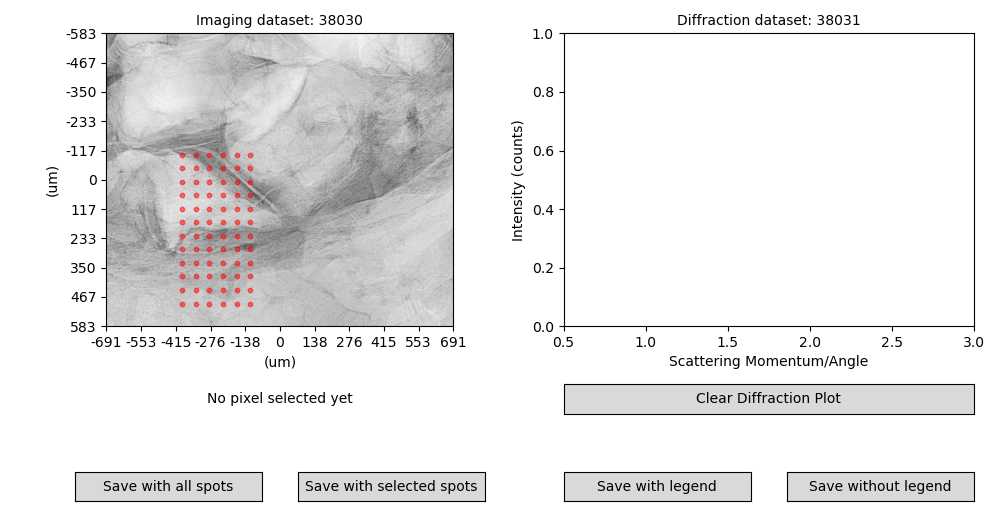

In [4]:
# Calculate the image pixel resolution
pixel_size = 0.54

# Calculate the aspect ratio for the first subplot based on its limits
x_range_img = len(proj[0])
y_range_img = len(proj)
aspect_ratio = y_range_img / x_range_img

selection_range = y_range_img / 50  # Range of spot selection
summation_range = [max(0, np.argmax(qvals >= IntegrationRange[0])),min(len(qvals), np.argmax(qvals >= IntegrationRange[1]))]

# Create a single figure with space for controls and subplots
fig_width = 10  # total figure width
subplot_width = fig_width / 2  # each subplot gets approximately half the width
fig_height = subplot_width * aspect_ratio + 1  # add extra height for controls

# Create figure with GridSpec
fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(3, 2, height_ratios=[1.0, 0.1, 0.1], width_ratios=[1, 1], figure=fig)

temp = []
scatter_plots = []
xrd = []

img_array = np.array(proj) # Convert image to numpy array for matplotlib

def scale_x(value, tick_number):
    x = ((value * binning) - 1280) * pixel_size
    return f'{x:.{0}f}' 
def scale_y(value, tick_number):
    y = ((value * binning) - 1080) * pixel_size
    return f'{y:.{0}f}'

## Left Column ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# Cell (0,0): Image
ax1 = fig.add_subplot(gs[0, 0])
img_plot = ax1.imshow(img_array, cmap='Greys', aspect='equal')
ax1.set_title('Imaging dataset: ' + str(imgfileno), fontsize=10)
ax1.set_xlim(0, x_range_img)
ax1.set_ylim(y_range_img, 0)
ax1.set_xlabel("(um)")
ax1.set_ylabel("(um)")

ax1.xaxis.set_major_locator(MultipleLocator(256/binning))
ax1.yaxis.set_major_locator(MultipleLocator(216/binning))

ax1.xaxis.set_major_formatter(FuncFormatter(scale_x))
ax1.yaxis.set_major_formatter(FuncFormatter(scale_y))


def plot_scatter(axs, kbx, kby):
    combinedsc = [sc for sc in scatter_plots]
    for i in range(len(kbx)):
        for j in range(len(kby)):
            #temp.append([kbx[i], kby[j], np.sum(data[j,i,summation_range[0]:summation_range[1]])])
            temp.append([kbx[i], kby[j]])
            sc = axs.scatter(kbx[i], kby[j], c='r', s=10, alpha=0.5)
            scatter_plots.append(sc)

plot_scatter(ax1, kbx, kby)
#all_spots = True
def save_img_plot(event, all_spots):
    img_fig = plt.subplots()
    img_fig_plot = img_fig[1].imshow(img_array, cmap='Greys', aspect='equal')
    img_fig[1].set_title('Imaging dataset: ' + str(imgfileno), fontsize=10)
    img_fig[1].set_xlim(0, x_range_img)
    img_fig[1].set_ylim(y_range_img, 0)
    img_fig[1].set_xlabel("(um)")
    img_fig[1].set_ylabel("(um)")

    img_fig[1].xaxis.set_major_locator(MultipleLocator(256/binning))
    img_fig[1].yaxis.set_major_locator(MultipleLocator(216/binning))
    
    img_fig[1].xaxis.set_major_formatter(FuncFormatter(scale_x))
    img_fig[1].yaxis.set_major_formatter(FuncFormatter(scale_y))
    
    if(all_spots): plot_scatter(img_fig[1], kbx, kby)
    
    df = pd.DataFrame(xrd, columns=['kbx', 'kby'])
    df = df.drop_duplicates(subset=['kbx', 'kby'])
    
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(0, len(xrd))
                     
    for no, row in df.iterrows():
        text = "(" + str(row['kbx']+1) + " " + str(row['kby']+1) + ")"
        color = cmap(norm(no))
        
        img_fig[1].scatter(kbx[row['kbx']], kby[row['kby']], c=color, s=10)
    
    path = visitpath + "/processing/ImageingPlot.tiff"
    img_fig[0].savefig(path, format='tiff')

def save_img_plot_all(event):
    save_img_plot(event, True)
def save_img_plot_sel(event):
    save_img_plot(event, False)

# Cell (1,0): Text display
ax2 = fig.add_subplot(gs[1, 0])
ax2.text(0.5, 0.5, "No pixel selected yet", 
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax2.transAxes)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_frame_on(False)

# Cell (2,0): Button
gss = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2, 0])
ax3_l = fig.add_subplot(gss[0, 0])
save_img_button_all = Button(ax3_l, 'Save with all spots')
ax3_r = fig.add_subplot(gss[0, 1])
save_img_button_sel = Button(ax3_r, 'Save with selected spots')


## Right Column ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# Cell (0,1): Second figure
ax4 = fig.add_subplot(gs[0, 1])
ax4.set_xlim(min(qvals), max(qvals))
ax4.set_ylim(0, 1.0)
ax4.set_title('Diffraction dataset: ' + str(diffileno), fontsize=10)
ax4.set_xlabel("Scattering Momentum/Angle")
ax4.set_ylabel("Intensity (counts)")

def update_diff_plot(axs, legend):
    df = pd.DataFrame(xrd, columns=['kbx', 'kby'])
    df = df.drop_duplicates(subset=['kbx', 'kby'])
    c = 0
    y_range = 10.0
    axs.clear()
    axs.set_title('Diffraction dataset: ' + str(diffileno), fontsize=10)
    axs.set_xlabel("Scattering Momentum/Angle")
    axs.set_ylabel("Intensity (counts)")
    axs.set_xlim(min(qvals), max(qvals))
    axs.set_ylim(0, 1.0)
    
    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(0, len(xrd))
                     
    for no, row in df.iterrows():
        text = "(" + str(row['kby']+1) + " " + str(row['kbx']+1) + ")"
        color = cmap(norm(no))
        
        ax1.scatter(kbx[row['kbx']], kby[row['kby']], color=color, s=10)
        
        if(legend): axs.plot(qvals, data[row['kby'],row['kbx']]+c, color=color, label=text)
        else:       axs.plot(qvals, data[row['kby'],row['kbx']]+c, color=color)
        y_range = max(c+max(data[row['kby'],row['kbx']])*1.050, y_range)
        c += 10
    axs.set_ylim(0, y_range)
    axs.legend(loc='upper left', fontsize=8)

def clear_plots(event):
    # Reset dataset
    xrd.clear()
    # Reset figure diffraction
    ax4.clear()
    ax4.set_title('Diffraction dataset: ' + str(diffileno), fontsize=10)
    ax4.set_xlabel("Scattering Momentum/Angle")
    ax4.set_ylabel("Intensity (counts)")
    ax4.set_xlim(min(qvals), max(qvals))
    ax4.set_ylim(0, 1.0)
    
    # Reset figure imaging
    ax1.clear()
    img_plot = ax1.imshow(img_array, cmap='Greys', aspect='equal')
    ax1.set_title('Imaging dataset: ' + str(imgfileno), fontsize=10)
    ax1.set_xlim(0, x_range_img)
    ax1.set_ylim(y_range_img, 0)
    ax1.set_xlabel("(um)")
    ax1.set_ylabel("(um)")
    
    ax1.xaxis.set_major_locator(MultipleLocator(256/binning))
    ax1.yaxis.set_major_locator(MultipleLocator(216/binning))
    
    ax1.xaxis.set_major_formatter(FuncFormatter(scale_x))
    ax1.yaxis.set_major_formatter(FuncFormatter(scale_y))
    
    plot_scatter(ax1, kbx, kby)
    
    ## ## ## ## ## ## ## ## ##
    
    fig.canvas.draw_idle()

def save_dif_plot(event, legend):
    dif_fig = plt.subplots()
    update_diff_plot(dif_fig[1], legend)
    path = visitpath + "/processing/DiffractionPlot.tiff"
    dif_fig[0].savefig(path, format='tiff')

def save_dif_plot_leg(event):
    save_dif_plot(event, True)
def save_dif_plot_cle(event):
    save_dif_plot(event, False)

# Cell (1,1): Button
ax5 = fig.add_subplot(gs[1, 1])
clear_dif_button = Button(ax5, 'Clear Diffraction Plot')

# Cell (2,1): Button
gss = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2, 1])
ax6_l = fig.add_subplot(gss[0, 0])
save_dif_button_leg = Button(ax6_l, 'Save with legend')
ax6_r = fig.add_subplot(gss[0, 1])
save_dif_button_cle = Button(ax6_r, 'Save without legend')


## Actions ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

def onclick(event):
    if event.inaxes == ax1:  # Only respond to clicks in the first subplot
        if event.xdata is not None and event.ydata is not None:
            x = int(event.xdata)
            y = int(event.ydata)
            
            if 0 <= x < x_range_img and 0 <= y < y_range_img:
                rgb_value = img_array[y, x]  # Note: y,x order for array indexing # Get the RGB value at the clicked position
                kbx_i = np.where((kbx >= x-selection_range) & (kbx <= x+selection_range))[0] # Get kbx index at the clicked position
                kby_i = np.where((kby >= y-selection_range) & (kby <= y+selection_range))[0] # Get kby index at the clicked position
                
                # Update selection parameters in cell 1,0
                ax2.clear()
                ax2.set_xticks([])
                ax2.set_yticks([])
                if len(kbx_i) & len(kby_i) > 0:
                    kb_ix = kbx_i.item()
                    kb_iy = kby_i.item()
                    ax2.text(0.5, 0.5, 
                        f"Selected pixel: X: {x}, Y: {y} RGB: {rgb_value:.3f}\nDiffraction Spot ID (row,column): {kb_iy+1} {kb_ix+1}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax2.transAxes)
                    xrd.append((kb_ix, kb_iy))
                    update_diff_plot(ax4, True)
                else:
                    ax2.text(0.5, 0.5, 
                        f"Selected pixel: X: {x}, Y: {y} RGB: {rgb_value:.3f}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax2.transAxes)
                fig.canvas.draw_idle()

# Connect the events
fig.canvas.mpl_connect('button_press_event', onclick)
clear_dif_button.on_clicked(clear_plots)
save_img_button_all.on_clicked(save_img_plot_all)
save_img_button_sel.on_clicked(save_img_plot_sel)
save_dif_button_leg.on_clicked(save_dif_plot_leg)
save_dif_button_cle.on_clicked(save_dif_plot_cle)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()